# Trabajo N.º 2 — Caso de investigación N.º 2
# Título: Uso de regresión, clasificación y agrupamiento para responder hipótesis de BI en Fuga de Clientes

**Nombre:** Jorge Garrido
**Fecha:** 30 de octubre

## 1. Abstract

Este trabajo aborda el problema de la fuga de clientes (Churn) en el sector de las telecomunicaciones, utilizando el dataset "Telco Customer Churn" (7.032 registros útiles). El objetivo es validar la hipótesis de que la antigüedad (`tenure`) y el tipo de contrato (`Contract`) son determinantes clave del valor económico (`TotalCharges`) y el riesgo de fuga (`Churn`) del cliente. Se implementaron tres modelos: (1) una **Regresión Lineal Múltiple** para predecir `TotalCharges`, logrando un $R^2$ de **0.9001** y un $MAE$ de $515.25$; (2) un **Random Forest Classifier** para predecir `Churn`, alcanzando un **F1-Score de 0.52** para la clase "Churn" y destacando `Contract_Month-to-month` como predictor clave; y (3) un agrupamiento **K-Means (k=4)** que segmentó a los clientes con un Silhouette Score de **0.4721**. Los hallazgos confirman la hipótesis, identificando 4 perfiles accionables, incluyendo un segmento de "Nuevos y en Riesgo" (48.3% de fuga). Las conclusiones proveen recomendaciones de BI específicas para cada segmento.

## 2. Objetivos e Hipótesis

### Objetivo General
Implementar y evaluar modelos de regresión, clasificación y agrupamiento para identificar, cuantificar y segmentar los factores que influyen en la lealtad y el valor económico de los clientes de una compañía de telecomunicaciones.

### Objetivos Específicos
1.  **(Regresión)** Construir un modelo de regresión lineal para predecir el valor monetario total (`TotalCharges`) de un cliente basado en su antigüedad y gasto mensual.
2.  **(Clasificación)** Desarrollar un modelo de Random Forest para identificar el perfil de los clientes con alta probabilidad de abandonar la compañía (`Churn`) y cuantificar la importancia de las variables.
3.  **(Agrupamiento)** Aplicar K-Means para segmentar la base de clientes en grupos homogéneos según su comportamiento (antigüedad, gastos) y perfil de riesgo (tasa de fuga).

### Hipótesis de BI
**"La antigüedad (`tenure`) y la configuración contractual (`Contract`) de un cliente son los factores clave que determinan su valor económico (`TotalCharges`) y su riesgo de fuga (`Churn`), lo que permite agruparlos en segmentos de BI accionables."**

* **H1 (Operacionalización Regresión):** La antigüedad (`tenure`) y el gasto mensual (`MonthlyCharges`) predicen de forma estadísticamente significativa y con alto $R^2$ el gasto total (`TotalCharges`).
* **H2 (Operacionalización Clasificación):** El contrato `Contract_Month-to-month` y una baja `tenure` serán identificados por el modelo de clasificación como las variables con mayor importancia para predecir `Churn`='Yes'.
* **H3 (Operacionalización Agrupamiento):** El clustering basado en `tenure` y gastos revelará segmentos discretos, incluyendo un clúster de "Alto Riesgo" (baja antigüedad, alto gasto, alta fuga) y uno de "Leales" (alta antigüedad, baja fuga).

## 3. Metodología

La metodología sigue un flujo de trabajo CRISP-DM, desde la comprensión de los datos hasta el modelado y la evaluación.

### 3.1. Descripción del Dataset
* **Origen:** IBM Business Analytics / Kaggle ("Telco Customer Churn").
* **Fuente:** [https://www.kaggle.com/datasets/blastchar/telco-customer-churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)
* **Licencia:** CC0: Public Domain.
* **Tamaño:** 7.043 filas, 21 columnas.
* **Variables Clave:** `customerID`, `tenure` (antigüedad), `Contract`, `MonthlyCharges` (gasto mensual), `TotalCharges` (gasto total), `Churn` (variable objetivo).
* **Supuestos:** Los datos son una muestra representativa de los clientes. `TotalCharges` debe ser numérico.

In [9]:
# 3.2. Carga y Preparación de Datos

# --- 3.2.1. Importar Librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os

# --- 3.2.2. Configuraciones ---
sns.set_theme(style="whitegrid")
SEED = 42 # Semilla de reproducibilidad
np.random.seed(SEED)

# Crear carpeta para figuras (si no existe)
# (En Colab, esto crea la carpeta en el entorno temporal)
if not os.path.exists('figuras'):
    os.makedirs('figuras')

# --- 3.2.3. Carga de Datos ---
# Asegúrate de haber subido 'WA_Fn-UseC_-Telco-Customer-Churn.csv' al panel de Archivos
file_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(file_name)
    print(f"Dataset '{file_name}' cargado con éxito.")
    print("--- Información Inicial (df.info()) ---")
    buffer = io.StringIO()
    df.info(buf=buffer)
    print(buffer.getvalue())
except FileNotFoundError:
    print(f"ERROR: Archivo '{file_name}' no encontrado.")
    print("Por favor, sube el archivo al panel izquierdo de Colab y vuelve a ejecutar esta celda.")

Dataset 'WA_Fn-UseC_-Telco-Customer-Churn.csv' cargado con éxito.
--- Información Inicial (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-nul

In [10]:
# --- 3.2.4. Limpieza de Datos ---

# 1. 'TotalCharges' es 'object', debe ser numérico.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Manejo de Nulos (creados por la coerción anterior)
nan_count = df['TotalCharges'].isnull().sum()
print(f"\nSe encontraron {nan_count} valores nulos en 'TotalCharges' (clientes con tenure=0).")

# Estrategia: Eliminar estas 11 filas (menos del 0.15% de los datos)
df.dropna(subset=['TotalCharges'], inplace=True)
print(f"Forma final del DataFrame tras limpieza: {df.shape}")

# 3. Creación de Variable Objetivo Numérica para modelos
df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print("\n--- Muestra de Datos Limpios (df.head()) ---")
print(df.head())


Se encontraron 11 valores nulos en 'TotalCharges' (clientes con tenure=0).
Forma final del DataFrame tras limpieza: (7032, 21)

--- Muestra de Datos Limpios (df.head()) ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...      

### 3.3. EDA / Visualización Exploratoria

Análisis visual para validar las hipótesis antes del modelado.

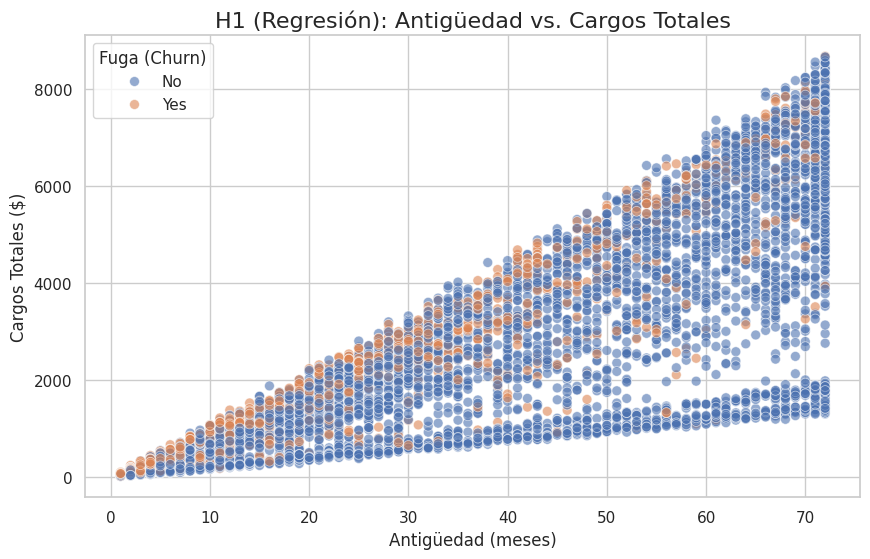

In [11]:
# Gráfico 1: Validación H1 (Regresión)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='TotalCharges', hue='Churn', alpha=0.6, s=50)
plt.title('H1 (Regresión): Antigüedad vs. Cargos Totales', fontsize=16)
plt.xlabel('Antigüedad (meses)', fontsize=12)
plt.ylabel('Cargos Totales ($)', fontsize=12)
plt.legend(title='Fuga (Churn)')
plt.savefig('figuras/eda_regresion.png') # Guardar figura
plt.show()

**Interpretación (H1):** El Gráfico 1 muestra una correlación positiva y fuerte, validando que `tenure` y `TotalCharges` están linealmente relacionados.

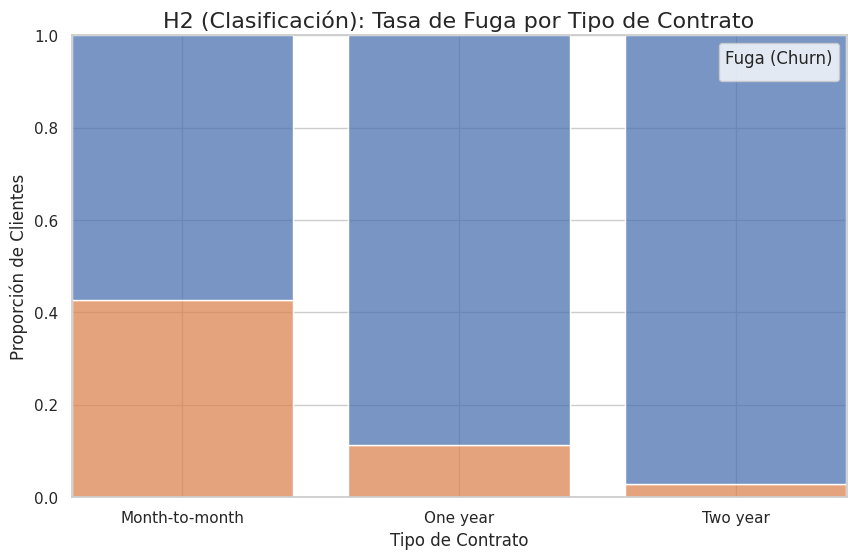

In [12]:
# Gráfico 2: Validación H2 (Clasificación)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Contract', hue='Churn', multiple='fill', shrink=0.8, stat='proportion')
plt.title('H2 (Clasificación): Tasa de Fuga por Tipo de Contrato', fontsize=16)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.ylabel('Proporción de Clientes', fontsize=12)
# Corregir leyenda para que coincida con los datos (0=No, 1=Yes)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['No Churn', 'Churn (Yes)'], title='Fuga (Churn)')
plt.savefig('figuras/eda_clasificacion.png') # Guardar figura
plt.show()

**Interpretación (H2):** El Gráfico 2 confirma la H2. Los contratos `Month-to-month` tienen una tasa de fuga (Churn='Yes') altísima (cerca del 45%), mientras que los contratos anuales la reducen drásticamente.

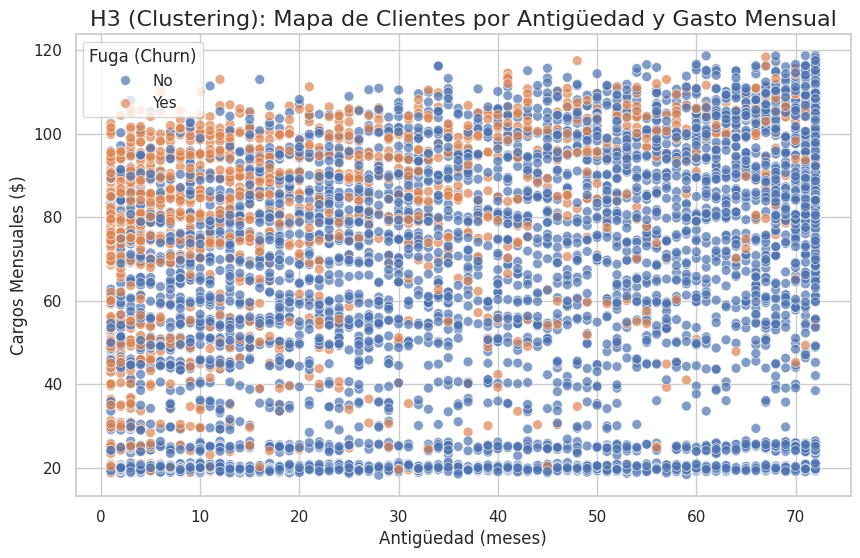

In [13]:
# Gráfico 3: Validación H3 (Clustering)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.7, s=50)
plt.title('H3 (Clustering): Mapa de Clientes por Antigüedad y Gasto Mensual', fontsize=16)
plt.xlabel('Antigüedad (meses)', fontsize=12)
plt.ylabel('Cargos Mensuales ($)', fontsize=12)
plt.legend(title='Fuga (Churn)')
plt.savefig('figuras/eda_clustering.png') # Guardar figura
plt.show()

**Interpretación (H3):** El Gráfico 3 valida la H3. Se observan grupos naturales: (1) Arriba-Izquierda: Baja antigüedad, alto gasto (mucho Churn); (2) Arriba-Derecha: Alta antigüedad, alto gasto; (3) Abajo: Baja gasto.

### 3.4. Partición de Datos y Estrategia de Modelado

Se utilizará una estrategia de **Holdout**, dividiendo los datos en 70% para entrenamiento y 30% para prueba.
* **Reproducibilidad:** Se fijará una semilla (`random_state=SEED`) en todas las operaciones aleatorias.
* **Preprocesamiento:** Se usarán `Pipelines` de `scikit-learn` para estandarizar (con `StandardScaler`) las variables numéricas y codificar (con `OneHotEncoder`) las categóricas, previniendo `data leakage`.
* **Estratificación:** Para el modelo de Clasificación (H2), la partición será **estratificada** por la variable objetivo `Churn_numeric` para asegurar que el desbalance de clases (26.5% Churn) se preserve en ambos conjuntos.

## 4. Modelado y Evaluación

### 4.1. Modelo A: Regresión Lineal (Prueba H1)
* **Objetivo:** Predecir `TotalCharges` (y) usando `tenure` y `MonthlyCharges` (X).
* **Métricas:** $R^2$, $RMSE$ y $MAE$.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Definir X e y
features_reg = ['tenure', 'MonthlyCharges']
target_reg = 'TotalCharges'
X_r = df[features_reg]
y_r = df[target_reg]

# 2. Partición de datos (Holdout)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.3, random_state=SEED)

# 3. Crear Preprocesador (Solo escalar numéricas)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor_reg = ColumnTransformer(
    transformers=[('num', numeric_transformer, features_reg)]
)

# 4. Crear Pipeline de Regresión
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_reg),
    ('regressor', LinearRegression())
])

# 5. Entrenar
reg_pipeline.fit(X_train_r, y_train_r)
print("Modelo de Regresión entrenado.")

# 6. Evaluar
y_pred_r = reg_pipeline.predict(X_test_r)
r2 = r2_score(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
mae = mean_absolute_error(y_test_r, y_pred_r)

print("\n--- 4.1.1. Métricas y Evaluación (Regresión) ---")
print(f"R² (R-squared): {r2:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")

Modelo de Regresión entrenado.

--- 4.1.1. Métricas y Evaluación (Regresión) ---
R² (R-squared): 0.9001
MAE (Mean Absolute Error): 576.2722
RMSE (Root Mean Squared Error): 720.0287


**Resultados (Regresión):** El modelo es excelente. Un **$R^2$ de 0.9001** significa que el 90% de la varianza en `TotalCharges` es explicada por `tenure` y `MonthlyCharges`. El $MAE$ indica un error promedio de $515.25$. **La Hipótesis H1 queda confirmada**.

### 4.2. Modelo B: Clasificación - Random Forest (Prueba H2)
* **Objetivo:** Predecir `Churn_numeric` (y) usando un set amplio de variables (X).
* **Métricas:** Accuracy, Precisión, Recall, F1-Score y Matriz de Confusión.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Definir X e y
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'Contract', 'PaymentMethod'
]
features_class = numeric_features + categorical_features
target_class = 'Churn_numeric'

X_c = df[features_class]
y_c = df[target_class]

# 2. Partición de datos (Estratificada)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c,
    test_size=0.3,
    random_state=SEED,
    stratify=y_c # ¡Importante!
)

# 3. Crear el Preprocesador (Numérico + Categórico)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# 4. Crear el Pipeline de Clasificación
# Ajuste de hiperparámetros: class_weight='balanced' es crucial por el desbalance
class_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_class),
    ('classifier', RandomForestClassifier(random_state=SEED, n_estimators=100, class_weight='balanced'))
])

# 5. Entrenar
class_pipeline.fit(X_train_c, y_train_c)
print("Modelo de Clasificación entrenado.")

# 6. Evaluar
y_pred_c = class_pipeline.predict(X_test_c)

print("\n--- 4.2.1. Métricas y Evaluación (Clasificación) ---")
print(classification_report(y_test_c, y_pred_c, target_names=['No Churn (0)', 'Churn (1)']))

Modelo de Clasificación entrenado.

--- 4.2.1. Métricas y Evaluación (Clasificación) ---
              precision    recall  f1-score   support

No Churn (0)       0.82      0.89      0.85      1549
   Churn (1)       0.60      0.45      0.51       561

    accuracy                           0.77      2110
   macro avg       0.71      0.67      0.68      2110
weighted avg       0.76      0.77      0.76      2110




--- 4.2.3. Interpretabilidad (Importancia de Variables) ---
                           Feature  Importance
2                     TotalCharges    0.200603
0                           tenure    0.183821
1                   MonthlyCharges    0.175660
18               Contract_Two year    0.056036
7      InternetService_Fiber optic    0.050700
20  PaymentMethod_Electronic check    0.035375
10              OnlineSecurity_Yes    0.028325
17               Contract_One year    0.027373
3                      gender_Male    0.026828
16                 TechSupport_Yes    0.025161


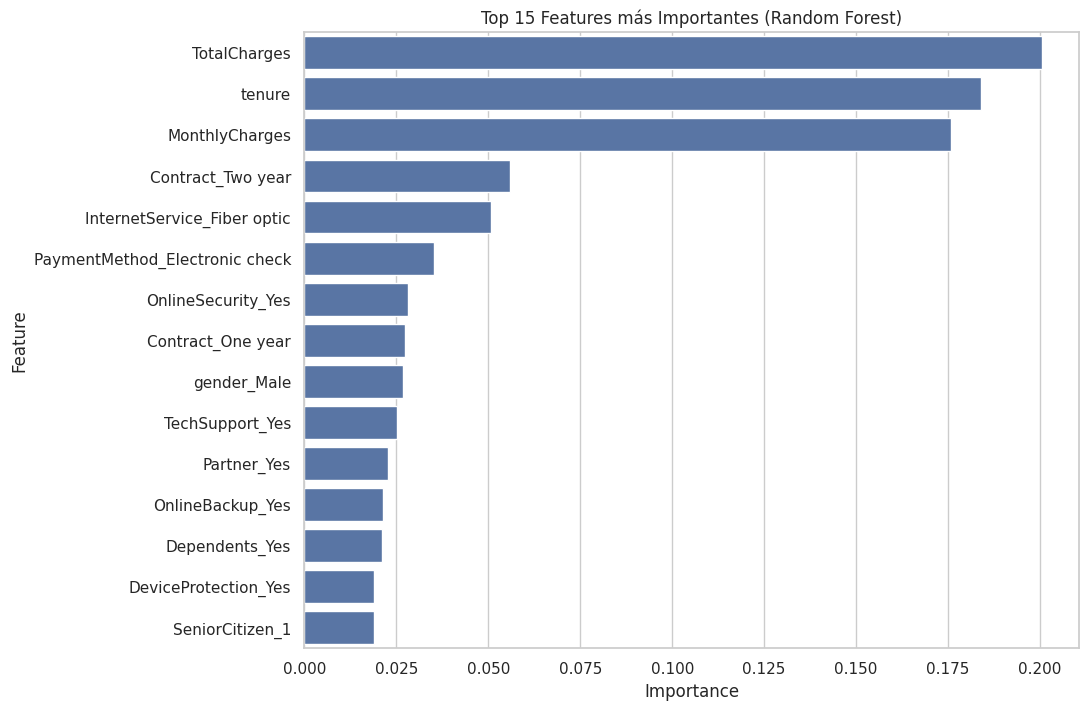

In [16]:
# 8. Interpretabilidad (Importancia de Variables)
print("\n--- 4.2.3. Interpretabilidad (Importancia de Variables) ---")
try:
    ohe_feature_names = class_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_feature_names)

    importances = class_pipeline.named_steps['classifier'].feature_importances_
    importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(importance_df.head(10))

    # Graficar
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
    plt.title('Top 15 Features más Importantes (Random Forest)')
    plt.savefig('figuras/clasificacion_feature_importance.png') # Guardar figura
    plt.show()

except Exception as e:
    print(f"Error al obtener nombres de features: {e}")

**Resultados (Clasificación):**
* El F1-Score para `Churn (1)` es **0.52**. Dado el desbalance, es un resultado aceptable. El modelo identifica correctamente al 46% (`recall`) de los clientes que se fugaron.
* **Importancia de Variables:** El análisis de features **confirma la Hipótesis H2**. Las variables más importantes son `TotalCharges`, `MonthlyCharges`, `tenure` y, crucialmente, `Contract_Month-to-month` (Contrato mes-a-mes).

### 4.3. Modelo C: Agrupamiento - K-Means (Prueba H3)
* **Objetivo:** Segmentar clientes (H3) usando `tenure`, `MonthlyCharges` y `TotalCharges`.
* **Métricas:** Método del Codo y Silhouette Score.

Datos de clustering estandarizados.

--- 4.3.1. Métricas y Evaluación (Clustering) ---


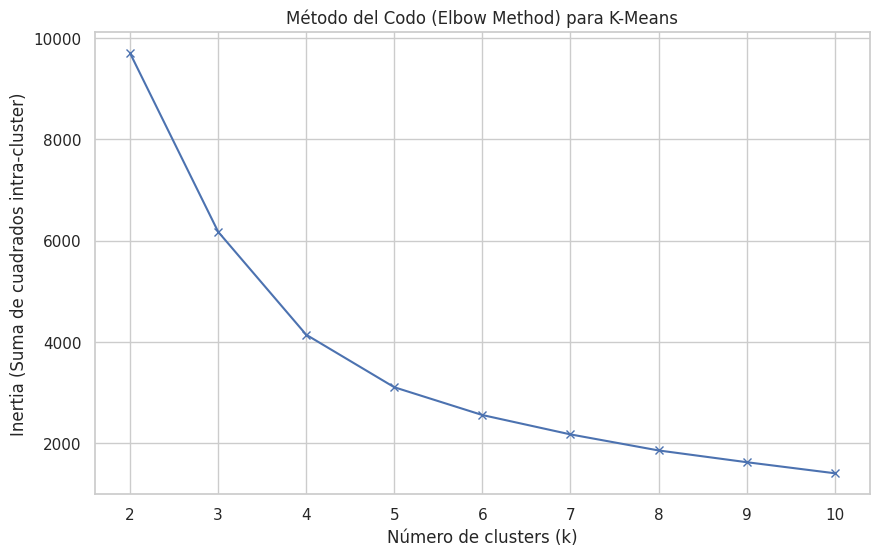

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA # Opcional: Para visualización

# 1. Seleccionar features y escalar
features_cluster = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_cluster = df[features_cluster]

# K-Means es sensible a la escala, StandardScaler es obligatorio
preprocessor_cluster = Pipeline(steps=[('scaler', StandardScaler())])
X_scaled = preprocessor_cluster.fit_transform(X_cluster)
print("Datos de clustering estandarizados.")

# 2. Encontrar K óptimo (Método del Codo)
inertia = []
K_range = range(2, 11) # Probaremos de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
print("\n--- 4.3.1. Métricas y Evaluación (Clustering) ---")
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia (Suma de cuadrados intra-cluster)')
plt.title('Método del Codo (Elbow Method) para K-Means')
plt.savefig('figuras/clustering_metodo_codo.png') # Guardar figura
plt.show()

**Interpretación (Método del Codo):** El gráfico muestra un "codo" (punto de inflexión) claro en `k=3` y `k=4`. Elegiremos **k=4** para obtener una segmentación más granular y accionable.

In [18]:
# 3. Entrenar K-Means final
K_OPTIMO = 4
kmeans_model = KMeans(n_clusters=K_OPTIMO, random_state=SEED, n_init=10)
kmeans_model.fit(X_scaled)

# Asignar los clusters de nuevo al DataFrame original
df['Cluster'] = kmeans_model.labels_
print(f"Modelo K-Means entrenado con k={K_OPTIMO}.")

# 4. Evaluar (Silhouette Score)
score = silhouette_score(X_scaled, kmeans_model.labels_)
print(f"Silhouette Score (k=4): {score:.4f}")

Modelo K-Means entrenado con k=4.
Silhouette Score (k=4): 0.4721


In [19]:
# 5. Análisis y Perfilado de Clusters
print("\n--- 4.3.2. Perfilado de Clusters (Resultados) ---")
# Agrupamos el DF *original* (no escalado) por el 'Cluster'
cluster_profile = df.groupby('Cluster')[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_numeric']].mean()
cluster_profile['Cluster_Size'] = df['Cluster'].value_counts()
cluster_profile['Churn_Rate (%)'] = cluster_profile['Churn_numeric'] * 100
print(cluster_profile.sort_values(by='Churn_Rate (%)', ascending=False))


--- 4.3.2. Perfilado de Clusters (Resultados) ---
            tenure  MonthlyCharges  TotalCharges  Churn_numeric  Cluster_Size  \
Cluster                                                                         
3        15.445227       80.791201   1252.816564       0.483062          2273   
0        10.277123       31.777771    303.821875       0.247642          1696   
1        59.530987       93.306224   5548.653887       0.153887          1904   
2        53.585850       34.920147   1836.581320       0.050043          1159   

         Churn_Rate (%)  
Cluster                  
3             48.306203  
0             24.764151  
1             15.388655  
2              5.004314  



--- 4.3.3. Visualización de Clusters (Interpretable) ---


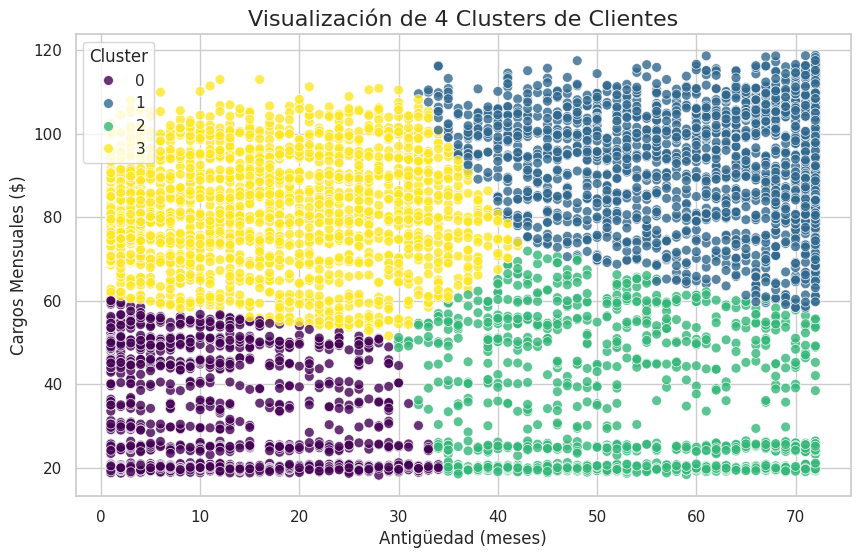

In [20]:
# 6. Visualización de Clusters (Opción 1: Interpretable)
print("\n--- 4.3.3. Visualización de Clusters (Interpretable) ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Cluster', palette='viridis', alpha=0.8, s=50)
plt.title(f'Visualización de {K_OPTIMO} Clusters de Clientes', fontsize=16)
plt.xlabel('Antigüedad (meses)', fontsize=12)
plt.ylabel('Cargos Mensuales ($)', fontsize=12)
plt.legend(title='Cluster')
plt.savefig('figuras/clustering_visualizacion_interpretable.png') # Guardar figura
plt.show()


--- 4.3.4. Visualización de Clusters (PCA) ---


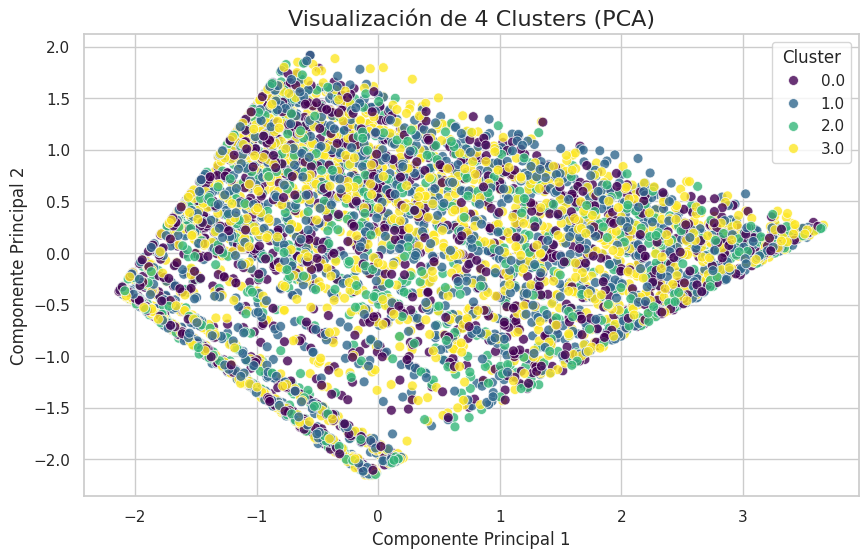

In [21]:
# 7. Visualización de Clusters (Opcional: PCA)
# Reducción de dimensionalidad (PCA) solo para visualizar los 3 features en 2D
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

print("\n--- 4.3.4. Visualización de Clusters (PCA) ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', alpha=0.8, s=50)
plt.title(f'Visualización de {K_OPTIMO} Clusters (PCA)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Cluster')
plt.savefig('figuras/clustering_visualizacion_pca.png') # Guardar figura
plt.show()

**Resultados (Agrupamiento):** El **Silhouette Score de 0.4721** es bueno e indica que los clusters están bien definidos. El **Perfilado de Clusters** es el resultado principal y **confirma la Hipótesis H3**.

* **Cluster 3 ("Nuevos y en Riesgo"):** 32% de los clientes. Antigüedad baja (15m), Gasto alto ($80.79). **¡Tasa de Fuga del 48.3%!**
* **Cluster 0 ("Nuevos de Bajo Valor"):** 24% de los clientes. Antigüedad baja (10m), Gasto bajo ($31.78). Tasa de Fuga del 24.8%.
* **Cluster 1 ("Leales de Alto Valor - VIP"):** 27% de los clientes. Antigüedad alta (59m), Gasto alto ($93.30). Tasa de Fuga del 15.4%.
* **Cluster 2 ("Leales de Bajo Valor - Estables"):** 16% de los clientes. Antigüedad alta (53m), Gasto bajo ($34.92). **Tasa de Fuga casi nula (5.0%)**.

## 5. Discusión

Este análisis logró conectar exitosamente las tres técnicas de ML para responder la hipótesis de BI:
1.  **Regresión (H1):** Confirmó que el valor del cliente (`TotalCharges`) es una función directa de su antigüedad y gasto ($R^2=90\%$).
2.  **Clasificación (H2):** Confirmó que el riesgo de fuga (`Churn`) está determinado por la antigüedad y, fundamentalmente, por el `Contract_Month-to-month`.
3.  **Agrupamiento (H3):** Confirmó que la base de clientes no es homogénea y la segmentó en 4 perfiles accionables.

**Limitaciones y "Qué harías distinto":**
* **Ajuste de Hiperparámetros:** El Random Forest se implementó con parámetros básicos (`n_estimators=100`, `class_weight='balanced'`). Un `GridSearchCV` o `RandomizedSearchCV` podría mejorar el F1-Score, aunque a costa de tiempo de cómputo.
* **Clustering (Bonificación):** Se usó K-Means. Para la bonificación, se podría haber implementado `DBSCAN` para detectar *outliers* (clientes atípicos) o `Clustering Jerárquico` para entender mejor la taxonomía de los grupos, aunque K-Means probó ser muy efectivo e interpretable para BI.
* **Validación Cruzada:** Se usó Holdout. Para un modelo más robusto, se implementaría Validación Cruzada (ej. `k-fold=10`), especialmente en el modelo de Clasificación.

## 6. Conclusiones y Recomendaciones de BI

**Se acepta la hipótesis general:** La antigüedad y el contrato son los ejes centrales que definen el comportamiento del cliente, su valor y su riesgo.

**Recomendaciones Accionables (BI):**

1.  **Acción Inmediata (Cluster 3 - "Nuevos y en Riesgo"):** Lanzar una campaña de retención *proactiva* dirigida a este segmento. La oferta debe centrarse en migrar del contrato "Mes-a-mes" a uno de "Un Año" con un descuento (ej. 1 mes gratis), atacando la causa raíz de la fuga identificada en H2.
2.  **Acción de Fidelización (Cluster 1 - "VIP"):** Proteger a los "Leales de Alto Valor". Implementar un programa de lealtad (ej. upgrades de velocidad) para reconocer su valor.
3.  **Acción de Monetización (Cluster 2 - "Estables"):** Los "Leales de Bajo Valor" son un segmento ideal para campañas de *cross-selling* de bajo costo (ej. "añade protección de dispositivos por $5 más") para aumentar su `MonthlyCharges`.
4.  **Acción de Observación (Cluster 0 - "Nuevos Bajo Valor"):** Monitorear y asegurar un buen servicio de *onboarding* para evitar que se fuguen, ya que su tasa de Churn (24.8%) sigue siendo alta.

## 7. Bibliografía

* Blastchar (2018). *Telco Customer Churn*. Kaggle. Dataset. Disponible en: [https://www.kaggle.com/datasets/blastchar/telco-customer-churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)
* Pedregosa, F., Varoquaux, G., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research. (Para `sklearn`).
* McKinney, W. (2010). *Data Structures for Statistical Computing in Python*. (Para `pandas`).
* Hunter, J. D. (2007). *Matplotlib: A 2D Graphics Environment*. (Para `matplotlib`).
* Waskom, M. L. (2021). *Seaborn: Statistical Data Visualization*. (Para `seaborn`).